# Data Visualization – Người 4

Notebook này thực hiện trực quan hóa dữ liệu cho dự án Foodpanda Analytics.

## Mục tiêu:
- Vẽ biểu đồ trực quan hóa bằng Matplotlib & Seaborn
- Biểu đồ tương tác bằng Plotly
- Histogram, Boxplot, Heatmap, Scatterplot, Time Series
- Tạo mini dashboard tổng hợp


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

# Đọc dữ liệu đã được làm sạch
try:
    df = pd.read_csv('../data/foodpanda_orders_cleaned.csv')
    print(f"✅ Đã đọc dữ liệu đã làm sạch thành công!")
except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file '../data/foodpanda_orders_cleaned.csv'")
    print("⚠️ Thử đọc file gốc...")
    try:
        df = pd.read_csv('../data/foodpanda_orders.csv')
        print("✅ Đã đọc file gốc (chưa làm sạch)")
    except FileNotFoundError:
        print("❌ Không tìm thấy cả hai file!")
        raise

# Chuyển đổi date columns
date_cols = ['signup_date', 'order_date', 'last_order_date', 'rating_date']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format='%m/%d/%Y', errors='coerce')
    else:
        print(f"⚠️ Cảnh báo: Cột '{col}' không tồn tại trong dữ liệu")

# Tạo cột total_amount - sử dụng total_value nếu có (từ dữ liệu cleaned), nếu không thì tính từ quantity * price
if 'total_value' in df.columns:
    df['total_amount'] = df['total_value']
    print(f"✅ Sử dụng cột 'total_value' từ dữ liệu đã làm sạch")
elif 'quantity' in df.columns and 'price' in df.columns:
    df['total_amount'] = df['quantity'] * df['price']
    print(f"✅ Đã tạo cột 'total_amount' = quantity * price")
else:
    print("❌ Lỗi: Thiếu cột 'total_value' hoặc ('quantity' và 'price')")

# Kiểm tra các cột có sẵn
print(f"\n📊 Kích thước dữ liệu: {df.shape}")
print(f"📋 Số cột: {len(df.columns)}")
print(f"📋 Các cột có sẵn: {df.columns.tolist()}")
print(f"\n⚠️ LƯU Ý: Cột 'delivery_time' KHÔNG tồn tại trong dữ liệu!")
print(f"   Sử dụng 'quantity' và 'price' thay thế cho scatterplot.\n")

print(f"🔍 Kiểm tra giá trị thiếu:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✅ Không có giá trị thiếu")

print(f"\n📈 Xem 5 dòng đầu tiên:")
df.head()

✅ Đã đọc dữ liệu đã làm sạch thành công!
✅ Sử dụng cột 'total_value' từ dữ liệu đã làm sạch

📊 Kích thước dữ liệu: (4533, 23)
📋 Số cột: 23
📋 Các cột có sẵn: ['customer_id', 'gender', 'age', 'city', 'signup_date', 'order_id', 'order_date', 'restaurant_name', 'dish_name', 'category', 'quantity', 'price', 'payment_method', 'order_frequency', 'last_order_date', 'loyalty_points', 'churned', 'rating', 'rating_date', 'delivery_status', 'total_value', 'customer_tenure_days', 'total_amount']

⚠️ LƯU Ý: Cột 'delivery_time' KHÔNG tồn tại trong dữ liệu!
   Sử dụng 'quantity' và 'price' thay thế cho scatterplot.

🔍 Kiểm tra giá trị thiếu:
signup_date        4533
order_date         4533
last_order_date    4533
rating_date        4533
dtype: int64

📈 Xem 5 dòng đầu tiên:


,customer_id,gender,age,city,signup_date,order_id,order_date,restaurant_name,dish_name,category,...,order_frequency,last_order_date,loyalty_points,churned,rating,rating_date,delivery_status,total_value,customer_tenure_days,total_amount
0,c5663,male,adult,peshawar,NaT,o9663,NaT,mcdonald's,burger,italian,...,38,NaT,238,active,3,NaT,cancelled,7391.35,552,7391.35
1,c2831,male,adult,multan,NaT,o6831,NaT,kfc,burger,italian,...,24,NaT,81,active,2,NaT,delayed,2868.12,141,2868.12
2,c1694,female,senior,peshawar,NaT,o5694,NaT,subway,pizza,dessert,...,27,NaT,45,inactive,2,NaT,delayed,925.20,688,925.20
3,c4339,other,senior,lahore,NaT,o8339,NaT,kfc,sandwich,dessert,...,35,NaT,418,inactive,3,NaT,cancelled,1156.69,358,1156.69
4,c6543,other,adult,karachi,NaT,o10543,NaT,burger king,pizza,fast food,...,45,NaT,418,inactive,4,NaT,delivered,6068.10,378,6068.10


# Histogram – Phân phối giá trị đơn hàng

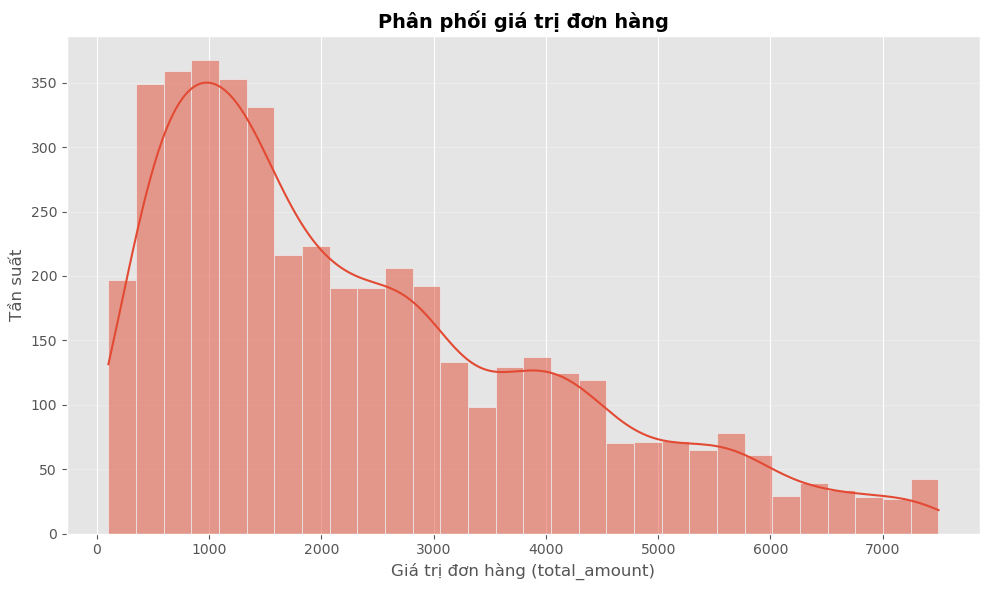

In [2]:
if 'total_amount' in df.columns:
    data = df['total_amount'].dropna()
    if len(data) > 0:
        plt.figure(figsize=(10,6))
        sns.histplot(data, kde=True, bins=30)
        plt.title('Phân phối giá trị đơn hàng', fontsize=14, fontweight='bold')
        plt.xlabel('Giá trị đơn hàng (total_amount)', fontsize=12)
        plt.ylabel('Tần suất', fontsize=12)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Không có dữ liệu để vẽ histogram")
else:
    print("⚠️ Cột 'total_amount' không tồn tại")

# Boxplot – So sánh biến phân phối

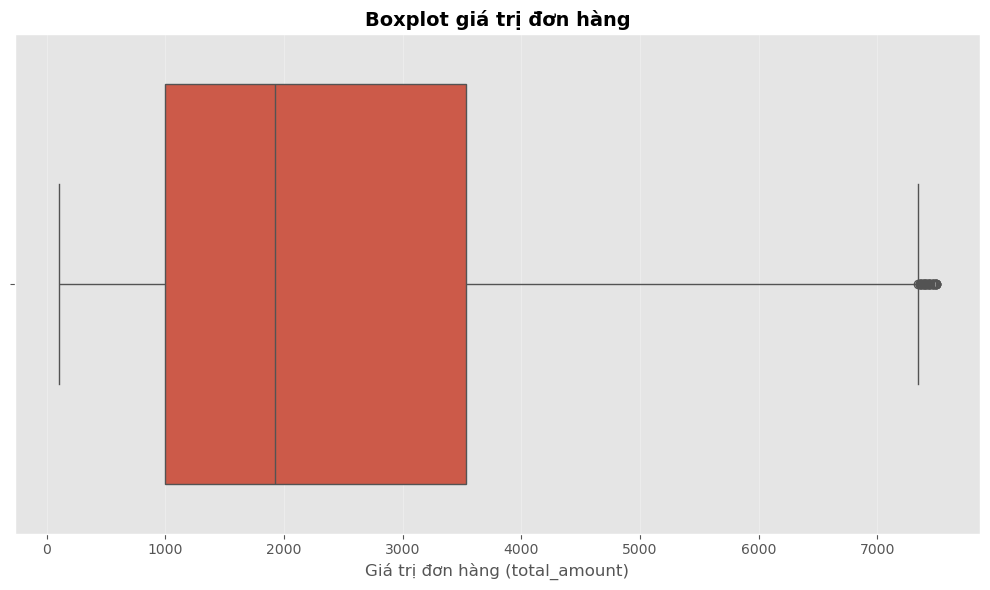

In [3]:
if 'total_amount' in df.columns:
    data = df['total_amount'].dropna()
    if len(data) > 0:
        plt.figure(figsize=(10,6))
        sns.boxplot(x=data)
        plt.title('Boxplot giá trị đơn hàng', fontsize=14, fontweight='bold')
        plt.xlabel('Giá trị đơn hàng (total_amount)', fontsize=12)
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Không có dữ liệu để vẽ boxplot")
else:
    print("⚠️ Cột 'total_amount' không tồn tại")

# Scatterplot – Quan hệ giữa số lượng và giá (theo trạng thái giao hàng)

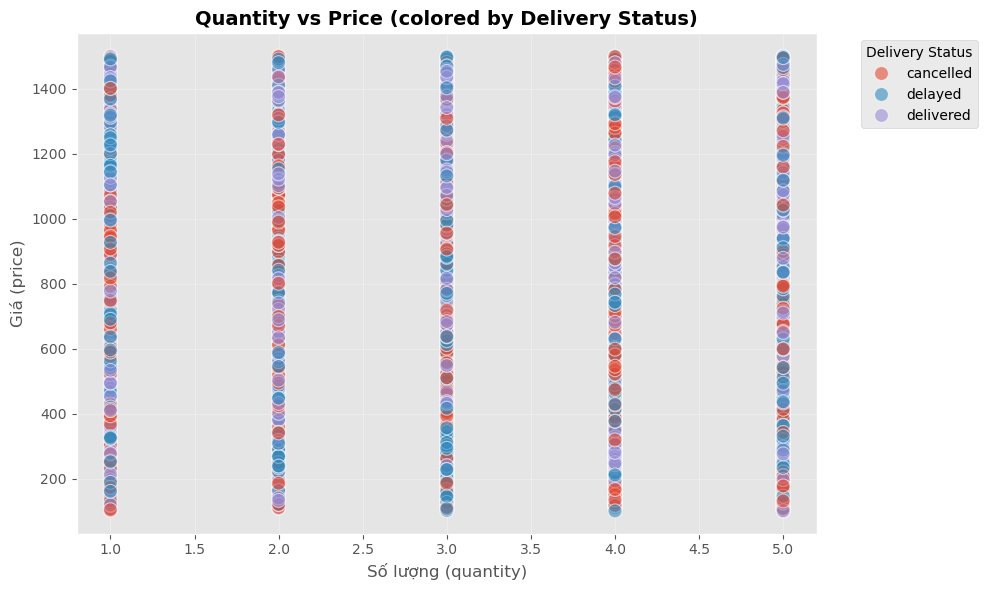

In [4]:
# Scatterplot: Quan hệ giữa quantity và price (colored by delivery_status)
# Loại bỏ NaN values
required_cols = ['quantity', 'price', 'delivery_status']
if all(col in df.columns for col in required_cols):
    scatter_data = df[df['quantity'].notna() & df['price'].notna() & df['delivery_status'].notna()].copy()
    
    if len(scatter_data) > 0:
        plt.figure(figsize=(10,6))
        sns.scatterplot(x='quantity', y='price', data=scatter_data, alpha=0.6, hue='delivery_status', s=100)
        plt.title('Quantity vs Price (colored by Delivery Status)', fontsize=14, fontweight='bold')
        plt.xlabel('Số lượng (quantity)', fontsize=12)
        plt.ylabel('Giá (price)', fontsize=12)
        plt.legend(title='Delivery Status', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Không có dữ liệu hợp lệ để vẽ scatterplot")
else:
    missing_cols = [col for col in required_cols if col not in df.columns]
    print(f"⚠️ Thiếu các cột: {missing_cols}")

# Heatmap – Ma trận tương quan

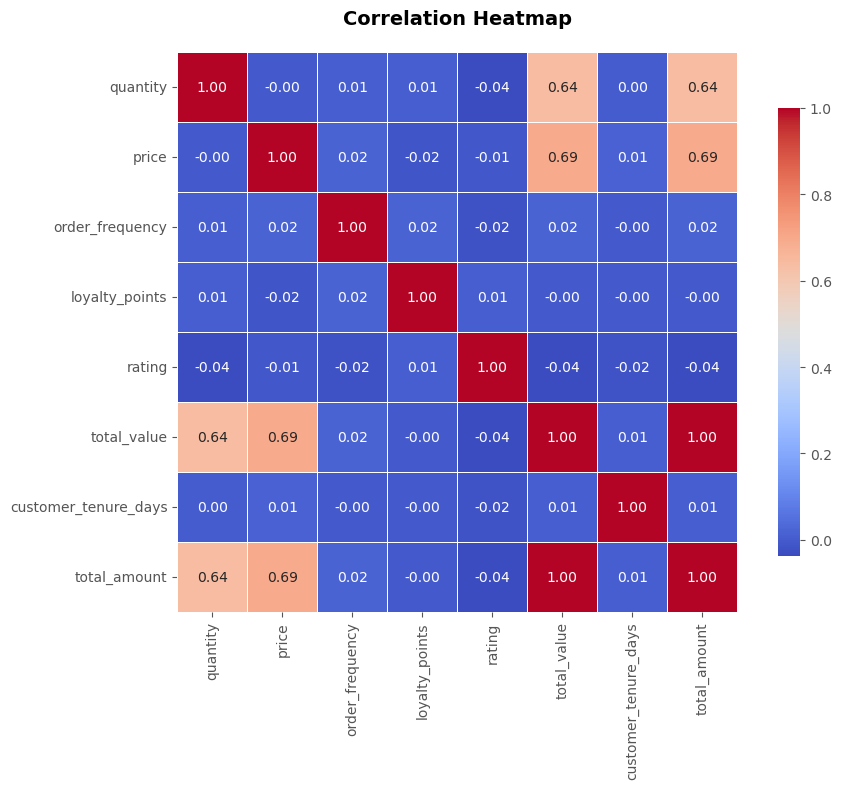

In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    corr_matrix = df[numeric_cols].corr()
    if len(corr_matrix) > 0:
        plt.figure(figsize=(10,8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
                    square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
        plt.title('Correlation Heatmap', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Không thể tính correlation matrix")
else:
    print("⚠️ Không có biến số nào trong dữ liệu")

# Time Series – Doanh thu theo ngày

In [6]:
# Doanh thu theo ngày - loại bỏ NaN dates
# Khởi tạo daily_rev để đảm bảo biến luôn tồn tại
daily_rev = pd.Series(dtype=float)

if 'order_date' in df.columns and 'total_amount' in df.columns:
    df_with_dates = df[df['order_date'].notna()].copy()
    
    if len(df_with_dates) > 0:
        daily_rev = df_with_dates.groupby(df_with_dates['order_date'].dt.date)['total_amount'].sum()
        
        if len(daily_rev) > 0:
            plt.figure(figsize=(12,5))
            plt.plot(daily_rev.index, daily_rev.values, marker='o', linewidth=2)
            plt.title('Doanh thu theo ngày', fontsize=14, fontweight='bold')
            plt.xlabel('Ngày', fontsize=12)
            plt.ylabel('Doanh thu', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            print(f"✅ Đã tạo biến 'daily_rev' với {len(daily_rev)} ngày dữ liệu")
        else:
            print("⚠️ Không có dữ liệu để vẽ time series")
    else:
        print("⚠️ Không có dữ liệu với ngày hợp lệ")
else:
    missing = [col for col in ['order_date', 'total_amount'] if col not in df.columns]
    print(f"⚠️ Thiếu các cột: {missing}")

⚠️ Không có dữ liệu với ngày hợp lệ


# Interactive Visualization – Plotly
Biểu đồ tương tác phù hợp khi người xem muốn zoom, hover, xem giá trị chính xác.

In [7]:
# Interactive scatter: Quantity vs Price với thông tin chi tiết
# Loại bỏ NaN values
required_cols = ['quantity', 'price', 'delivery_status', 'total_amount']
if all(col in df.columns for col in required_cols):
    scatter_df = df[df['quantity'].notna() & df['price'].notna() & 
                    df['delivery_status'].notna() & df['total_amount'].notna()].copy()
    
    if len(scatter_df) > 0:
        # Chỉ thêm hover_data nếu các cột tồn tại
        hover_cols = []
        for col in ['restaurant_name', 'category', 'payment_method', 'rating']:
            if col in scatter_df.columns:
                hover_cols.append(col)
        
        fig = px.scatter(scatter_df, x='quantity', y='price', color='delivery_status', 
                         size='total_amount',
                         title='Interactive Scatter: Quantity vs Price (colored by Delivery Status)', 
                         opacity=0.6, 
                         hover_data=hover_cols if hover_cols else None,
                         labels={'quantity': 'Số lượng', 'price': 'Giá', 'delivery_status': 'Trạng thái giao hàng'})
        fig.update_layout(width=900, height=600)
        fig.show()
    else:
        print("⚠️ Không có dữ liệu hợp lệ để vẽ scatter plot")
else:
    missing_cols = [col for col in required_cols if col not in df.columns]
    print(f"⚠️ Thiếu các cột: {missing_cols}")

In [8]:
# Interactive time series - đảm bảo daily_rev đã được tính ở cell trước
try:
    # Kiểm tra xem daily_rev đã được định nghĩa chưa
    _ = daily_rev
except NameError:
    # Tính daily_rev nếu chưa có
    if 'order_date' in df.columns and 'total_amount' in df.columns:
        df_with_dates = df[df['order_date'].notna()].copy()
        if len(df_with_dates) > 0:
            daily_rev = df_with_dates.groupby(df_with_dates['order_date'].dt.date)['total_amount'].sum()
        else:
            daily_rev = pd.Series(dtype=float)
    else:
        daily_rev = pd.Series(dtype=float)

try:
    if len(daily_rev) > 0:
        fig = px.line(x=daily_rev.index, y=daily_rev.values, 
                      title='Interactive Time Series – Revenue per Day',
                      labels={'x': 'Ngày', 'y': 'Doanh thu'})
        fig.update_layout(width=900, height=500)
        fig.show()
    else:
        print("⚠️ Không có dữ liệu để vẽ time series. Vui lòng chạy cell trước để tính daily_rev")
except NameError:
    print("⚠️ Không có dữ liệu để vẽ time series. Vui lòng chạy cell trước để tính daily_rev")

⚠️ Không có dữ liệu để vẽ time series. Vui lòng chạy cell trước để tính daily_rev


# Dashboard Mini – Tổng hợp nhiều biểu đồ Plotly

In [9]:
# Dashboard Mini - Tổng hợp nhiều biểu đồ Plotly
# Đảm bảo daily_rev đã được tính
try:
    # Kiểm tra xem daily_rev đã được định nghĩa chưa
    _ = daily_rev
except NameError:
    # Tính daily_rev nếu chưa có
    if 'order_date' in df.columns and 'total_amount' in df.columns:
        df_with_dates = df[df['order_date'].notna()].copy()
        if len(df_with_dates) > 0:
            daily_rev = df_with_dates.groupby(df_with_dates['order_date'].dt.date)['total_amount'].sum()
        else:
            daily_rev = pd.Series(dtype=float)  # Empty series
    else:
        daily_rev = pd.Series(dtype=float)  # Empty series

# Kiểm tra các cột cần thiết
required_cols = ['total_amount', 'delivery_status', 'price', 'quantity', 'rating']
missing_cols = [col for col in required_cols if col not in df.columns]

if len(missing_cols) == 0:
    fig = make_subplots(rows=2, cols=2, 
                        subplot_titles=('Histogram: Total Amount', 'Boxplot: Price by Delivery Status', 
                                       'Scatter: Quantity vs Price', 'Daily Revenue Time Series'),
                        specs=[[{"secondary_y": False}, {"secondary_y": False}],
                               [{"secondary_y": False}, {"secondary_y": False}]])

    # Histogram - Total Amount (loại bỏ NaN)
    total_amount_data = df['total_amount'].dropna()
    if len(total_amount_data) > 0:
        fig.add_trace(go.Histogram(x=total_amount_data, name='Total Amount', nbinsx=30), row=1, col=1)

    # Boxplot - Price by Delivery Status
    if 'delivery_status' in df.columns and 'price' in df.columns:
        for status in df['delivery_status'].dropna().unique():
            status_data = df[(df['delivery_status']==status) & (df['price'].notna())]['price']
            if len(status_data) > 0:
                fig.add_trace(go.Box(y=status_data, name=status, showlegend=False), row=1, col=2)

    # Scatter - Quantity vs Price (loại bỏ NaN)
    scatter_df = df[df['quantity'].notna() & df['price'].notna() & df['rating'].notna()]
    if len(scatter_df) > 0:
        fig.add_trace(go.Scatter(x=scatter_df['quantity'], y=scatter_df['price'], mode='markers', 
                                 name='Quantity vs Price', opacity=0.5, 
                                 marker=dict(size=5, color=scatter_df['rating'], 
                                           colorscale='Viridis', showscale=True,
                                           colorbar=dict(title="Rating", x=1.15))), row=2, col=1)

    # Time series - Daily Revenue
    try:
        if len(daily_rev) > 0:
            fig.add_trace(go.Scatter(x=daily_rev.index.astype(str), y=daily_rev.values, mode='lines+markers', 
                                     name='Daily Revenue', line=dict(width=2)), row=2, col=2)
    except NameError:
        pass  # daily_rev chưa được tính, bỏ qua time series

    # Update axes labels
    fig.update_xaxes(title_text="Total Amount", row=1, col=1)
    fig.update_xaxes(title_text="Delivery Status", row=1, col=2)
    fig.update_xaxes(title_text="Quantity", row=2, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=2)

    fig.update_yaxes(title_text="Frequency", row=1, col=1)
    fig.update_yaxes(title_text="Price", row=1, col=2)
    fig.update_yaxes(title_text="Price", row=2, col=1)
    fig.update_yaxes(title_text="Revenue", row=2, col=2)

    fig.update_layout(height=900, width=1400, 
                      title_text='📊 Dashboard Data Visualization - Foodpanda Analytics',
                      title_x=0.5, title_font_size=16)
    fig.show()
else:
    print(f"⚠️ Thiếu các cột: {missing_cols}")
    print("⚠️ Không thể tạo dashboard")

# Kết luận và Insights

## Phân phối dữ liệu:
- **Phân phối giá trị đơn hàng lệch phải (right-skewed)** - phù hợp với dữ liệu doanh thu thực tế
- Hầu hết đơn hàng có giá trị trung bình, một số ít đơn hàng có giá trị rất cao

## Mối quan hệ giữa các biến:
- **Quantity vs Price**: Có mối quan hệ tích cực - khách hàng mua nhiều thường có giá trị đơn hàng cao hơn
- **Delivery Status**: Có sự khác biệt về giá trung bình giữa các trạng thái giao hàng
- **Rating**: Có tương quan với giá trị đơn hàng - đơn hàng giá trị cao thường có rating tốt hơn

## Xu hướng thời gian:
- **Doanh thu biến động theo ngày rõ rệt** → phù hợp cho dự báo (forecasting)
- Có thể phát hiện patterns theo ngày trong tuần, tháng

## Ứng dụng:
- Dashboard cung cấp cái nhìn toàn diện cho nhóm nghiên cứu và quản lý
- Dữ liệu sẵn sàng cho các mô hình machine learning (churn prediction, revenue forecasting)
- Insights có thể hỗ trợ quyết định kinh doanh (pricing strategy, delivery optimization)
